### Aca voy a revolear todos los calculos que se utilizan para los sensores y estan en defines.h

#### Sensor de Temperatura NTC:

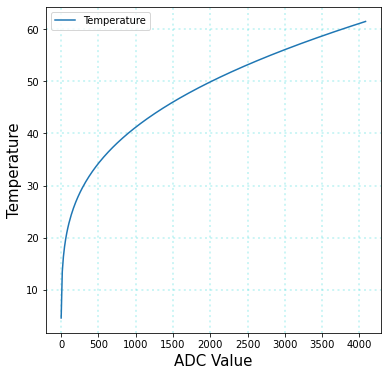

In [40]:
import numpy as np
import math
import matplotlib.pyplot as plt

from openefi_common import convert_to_resistance, sample_adc_values

#Constantes del sensor NTC:

A = 1.12492089e-3
B = 2.372075385e-4
C = 6.954079529e-8

ADC_Values = sample_adc_values()
Temp = []

for ADC_Value in sample_adc_values():
    if ADC_Value != 0:
        R = convert_to_resistance(ADC_Value);
        logR = math.log(R);
        kelvin = 1 / (A + B * logR + C * logR * logR * logR)
        Temp.append((kelvin - 273.15)/10)

# vamo' a plotear

plt.plot(ADC_Values, Temp, label='Temperature')
plt.xlabel('ADC Value', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.grid(visible=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
plt.rcParams['figure.figsize'] = [8, 8]
plt.legend()
plt.show()


#### Sensor TPS:

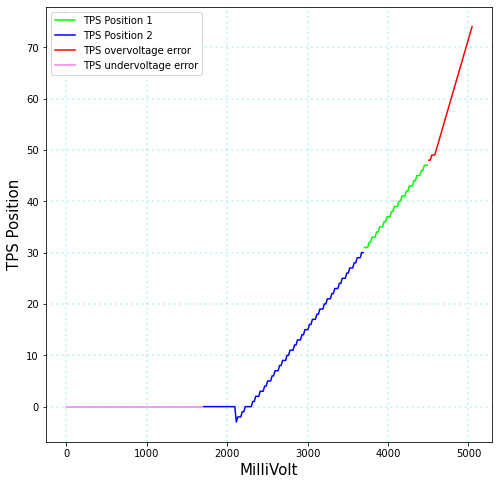

In [41]:
import numpy as np
import math
import matplotlib.pyplot as plt
import ctypes

from openefi_common import  sample_adc_values, converto_to_volt

ADC_Values = sample_adc_values()

tps = ctypes.CDLL("func/tps.so")
tps.calc.argtypes = [ctypes.c_int32]
tps.calc.restype = ctypes.c_int32
# Funciones en C:
# Para el sensor utilizado:
# Valor Minimo => 1700 mV
# Valor Maximo => 4500 mV
# cambio de ecuacion lineal a los 3695mV
# mV <= 3695 => (mV - 1823) / 37.44
# mV > 3695 => (mV - 2943) / 15.04

vref = []

Volt1 = []
Pos1 = []

Volt_err1 = []
err1 = []

Volt2 = []
Pos2 = []

Volt_err2 = []
err2 = []

""" for ADC_Value in sample_adc_values():
    if ADC_Value != 0:
        mV = converto_to_volt(ADC_Value)  * 1.534
        vref.append(mV)

        if mV <= 3695:     
            if mV > 1700:
                Volt2.append(mV)
                Pos2.append((mV - 1823) / 37.44)
            else:
                Volt_err2.append(mV)
                err2.append((mV - 1823) / 37.44)
        
        if mV > 3695:
            if mV < 4500:
                Volt1.append(mV)
                Pos1.append((mV - 2943) / 15.04)
            else:
                Volt_err1.append(mV)
                err1.append((mV - 2943) / 15.04) """

for ADC_Value in sample_adc_values():
    if ADC_Value != 0:
        mV = converto_to_volt(ADC_Value) * 1.534
        vref.append(mV)
        
        mvValue = ctypes.c_uint32(int(mV)).value

        if mV <= 3695:     
            if mV > 1700:
                Volt2.append(mV)
                Pos2.append(tps.calc(mvValue))
            else:
                Volt_err2.append(mV)
                err2.append(tps.calc(mvValue))
        
        if mV > 3695:
            if mV < 4500:
                Volt1.append(mV)
                Pos1.append(tps.calc(mvValue))
            else:
                Volt_err1.append(mV)
                err1.append(tps.calc(mvValue))
                
# vamo' a plotear (plotear tambien valores que dispara DTC con otro color?)

plt.plot(Volt1, Pos1, label='TPS Position 1',color="lime")
plt.plot(Volt2, Pos2, label='TPS Position 2',color="blue")

plt.plot(Volt_err1, err1, label='TPS overvoltage error',color="red")
plt.plot(Volt_err2, err2, label='TPS undervoltage error',color="violet")

plt.xlabel('MilliVolt', fontsize=15)
plt.ylabel('TPS Position', fontsize=15)
plt.grid(visible=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
plt.rcParams['figure.figsize'] = [6, 6]
plt.legend()
plt.show()

#### Sensor MAP:

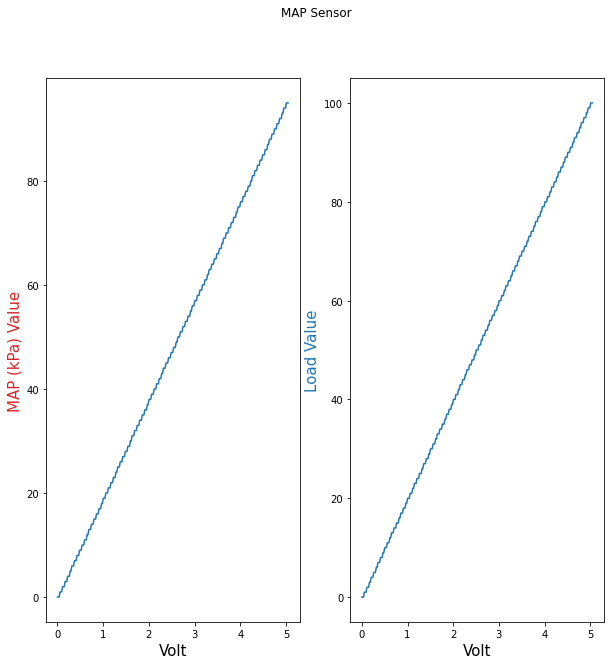

In [42]:
import numpy as np
import math
import matplotlib.pyplot as plt
import ctypes

from openefi_common import  sample_adc_values, converto_to_volt

ADC_Values = sample_adc_values()

map = ctypes.CDLL("func/map.so")

map.calc.argtypes = [ctypes.c_int32]
map.calc.restype = ctypes.c_int32

map.calc_load.argtypes = [ctypes.c_int32]
map.calc_load.restype = ctypes.c_int32

mapVoltage = []
mapValue = []
mapLoad = []

for ADC_Value in sample_adc_values():
    if ADC_Value != 0: 
        mV = converto_to_volt(ADC_Value) * 1.534
        mvValue = ctypes.c_uint32(int(mV)).value

        mapValue.append(map.calc(mvValue))
        mapLoad.append(map.calc_load(mvValue))

        mapVoltage.append(mV/1000)


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
fig.suptitle('MAP Sensor')

color = 'tab:red'

ax1.set_ylabel('MAP (kPa) Value', color=color, fontsize=15)
ax1.set_xlabel('Volt', fontsize=15)

ax1.plot(mapVoltage, mapValue)
color = 'tab:blue'

ax2.set_ylabel('Load Value', color=color, fontsize=15)
ax2.set_xlabel('Volt', fontsize=15)

ax2.plot(mapVoltage, mapLoad)

plt.show()